In [66]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import trompy as tp

from scipy.optimize import curve_fit

import dill

from utils import make_realigned_trials, get_time_moving, scale_vlim_to_data

rcParams['font.family'] = 'Arial'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.transparent'] = True
colors = ["#67AFD2", "#016895", "#F4795B", "#C74632"]

savefigs = False

DATAFOLDER = Path("..//data")
RESULTSFOLDER = Path("..//results")
FIGSFOLDER = Path("C:/Users/jmc010/Dropbox/Publications in Progress/Bazzino Roitman_sodium/figs")

In [67]:

with open(DATAFOLDER / "bazzino_data_with_clusters_and_dists.pickle", "rb") as f:
    data = dill.load(f)
x_array = data["x_array"]
snips_photo = data["snips_photo"]
snips_vel = data["snips_vel"]
pca = data["pca"]

with open(DATAFOLDER / "movement_data.pickle", "rb") as f:
    data = dill.load(f)

x_movement = data["x_movement"]
snips_movement = data["snips_movement"]

with open(DATAFOLDER / "sigmoidal_fits.pickle", "rb") as f:
    fits = dill.load(f)

fits_df_cluster_raw = fits["fits_df_cluster_raw"]
fits_df_clusterness = fits["fits_df_clusterness"]
fits_df_euclidean = fits["fits_df_euclidean"]

In [101]:
# trying to work out "missing" trials in new x_arrays
x_movement.query("condition == 'deplete' & infusiontype == '10NaCl'").id.unique()


array(['PB23', 'PB24', 'PB33', 'PB39', 'PB44', 'PB61', 'PB62', 'PB64',
       'PB70'], dtype=object)

In [102]:
x_array.query("condition == 'deplete' & infusiontype == '10NaCl'").id.unique()

array(['PB23', 'PB24', 'PB33', 'PB39', 'PB391', 'PB44', 'PB61', 'PB62',
       'PB64', 'PB70'], dtype=object)

In [68]:
# def realigned_trials(x_array, fits, verbose=True):

# # Realigning behavioral data to dopamine transitions
#     realigned_trials = []

#     for rat in x_array.id.unique():
        
#         x_array_r = x_array.query("id == @rat & condition == 'deplete' & infusiontype == '45NaCl'")

#         if rat not in fits.id.unique():
#             if verbose:
#                 print(f"Rat {rat} not found in fitted parameters, skipping.")
#             realigned_trials.append([np.nan] * len(x_array_r.trial))
#         else:
#             transition_point = int(fits.query("id == @rat").x0_orig.values[0])
#             realigned_trials.append(x_array_r.trial - transition_point)

#     return (
#         x_array
#         .assign(trial_aligned=tp.flatten_list(realigned_trials))
#         .dropna()
#         .reset_index(drop=True)
#         # .astype(int)  # Ensure the trial_aligned column is of integer type
#         )
    
        
#         # Update the original DataFrame
#         # print(len(x_array.loc[x_array.id == rat, 'trial_aligned']))
#         # x_array.loc[x_array.id == rat, 'trial_aligned'] = x_array_r['trial_aligned'].values
df2_dep_45 = x_array.query("condition == 'deplete' & infusiontype == '45NaCl'").reset_index(drop=True)

z = make_realigned_trials(df2_dep_45, fits_df_cluster_raw)

Rat PB27 not found in fitted parameters, skipping.
Rat PB48 not found in fitted parameters, skipping.


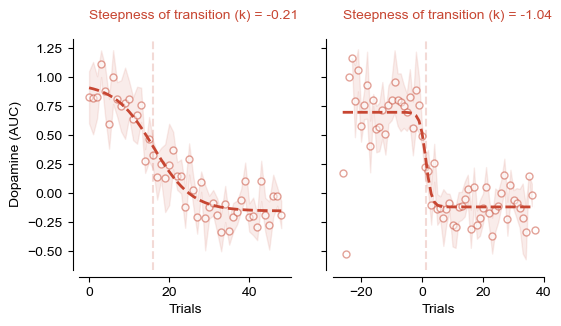

In [86]:
# make dopamine figure with trials and sigmoidal fit

def sigmoid(x, L, x0, k, b):
    """
    Sigmoid function.
    L: Maximum value of the curve
    x0: Midpoint of the sigmoid
    k: Steepness of the curve
    b: Baseline offset
    """
    return L / (1 + np.exp(-k * (x - x0))) + b

def plot_auc_and_sigmoid(df, column, ax=None, first_trial=0, include_steepness=True):
    
    if ax is None:
        f, ax = plt.subplots(figsize=(3,3))

    mean = df.groupby(column).mean(numeric_only=True).auc_snips
    sd = df.groupby(column).std(numeric_only=True).auc_snips.values
    sem = sd / np.sqrt(len(df.id.unique()))
    x, y = (mean.index, mean.values)

    ax.plot(x, y, color=colors[3], linestyle="", marker="o", markersize=5, markerfacecolor="white", alpha=0.5)
    ax.fill_between(x, y-sem, y+sem, color=colors[3], alpha=0.1)

    try:
        popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), -1, min(y)], maxfev=10000)
        # print(popt)
        y_fit = sigmoid(x, *popt)
        ax.plot(x, y_fit, color=colors[3], lw=2, linestyle="--")
        if include_steepness:
            ax.text(first_trial, 1.5, "Steepness of transition (k) = {:.2f}".format(popt[2]), color=colors[3])
    except:
        print("Failed to fit")

    # ax.axhline(0, color="k", linestyle="--", alpha=0.2)
    ax.axvline(popt[1], color=colors[3], linestyle="--", alpha=0.2)
    sns.despine(ax=ax, offset=5)

    ax.set_ylabel("Dopamine (AUC)")
    ax.set_xlabel("Trials")

    return popt


f, ax = plt.subplots(ncols=2, figsize=(6, 3), sharey=True)
popt_orig = plot_auc_and_sigmoid(z, "trial", ax=ax[0])
popt_realigned = plot_auc_and_sigmoid(z, "trial_aligned", ax=ax[1], first_trial=z.trial_aligned.min())

ax[1].set_ylabel("")

if savefigs:
    f.savefig(FIGSFOLDER / "realigned_transitions.png")



In [87]:
# shifts original AUC data based on fitted transition point
transition = int(popt_orig[1])

z = (z
     .assign(trial_shifted=lambda df_: df_.trial.sub(transition))
     )


In [88]:
z

,trial,id,condition,infusiontype,cluster_photo,cluster_vel,auc_snips,auc_vel,clusterness_photo,euclidean_diff,trial_aligned,trial_shifted
0,0,PB26,deplete,45NaCl,0,1,1.751713,-3.778940,0.644916,0.876384,-22.0,-16
1,1,PB26,deplete,45NaCl,0,1,1.606179,-3.247381,0.619632,0.823733,-21.0,-15
2,2,PB26,deplete,45NaCl,0,1,0.864692,-3.587596,0.616186,1.163286,-20.0,-14
3,3,PB26,deplete,45NaCl,0,1,0.995948,-2.667890,0.561951,0.631847,-19.0,-13
4,4,PB26,deplete,45NaCl,0,1,1.563953,-3.042829,0.579108,0.537403,-18.0,-12
...,...,...,...,...,...,...,...,...,...,...,...,...
387,44,PB75,deplete,45NaCl,1,1,-0.201180,3.736886,0.408037,-1.212506,18.0,28
388,45,PB75,deplete,45NaCl,1,0,-0.544147,4.750915,0.352093,-1.396677,19.0,29
389,46,PB75,deplete,45NaCl,1,0,-0.045962,3.688128,0.458332,-0.510602,20.0,30
390,47,PB75,deplete,45NaCl,1,1,-0.197668,1.650328,0.386716,-1.312865,21.0,31


Rat PB27 not found in fitted parameters, skipping.
Rat PB48 not found in fitted parameters, skipping.


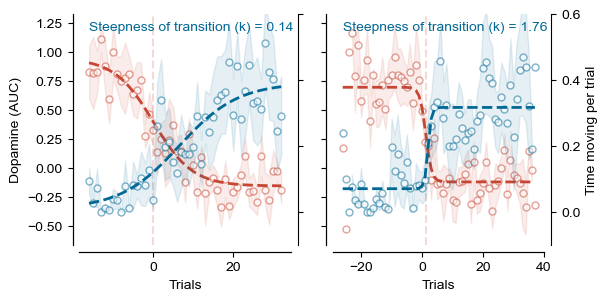

In [91]:
def plot_realigned_behaviour(df, column, ax=None, first_trial=0, include_steepness=False):
    
    if ax is None:
        f, ax = plt.subplots(figsize=(3,3))

    mean = df.groupby(column).mean(numeric_only=True).time_moving
    sd = df.groupby(column).std(numeric_only=True).time_moving.values
    sem = sd / np.sqrt(len(df.id.unique()))
    x, y = (mean.index, mean.values)

    ax.plot(x, y, color=colors[1], linestyle="", marker="o", markersize=5, markerfacecolor="white", alpha=0.5)
    ax.fill_between(x, y-sem, y+sem, color=colors[1], alpha=0.1)
    
    sns.despine(ax=ax, offset=5, right=True)
    ax.set_yticks([])
    ax.set_ylim([-0.1,0.6])
    
    try:
        popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), 1, min(y)], maxfev=10000)
        # print(popt)
        y_fit = sigmoid(x, *popt)
        ax.plot(x, y_fit, color=colors[1], lw=2, linestyle="--")
        if include_steepness:
            ax.text(first_trial, 0.55, "Steepness of transition (k) = {:.2f}".format(popt[2]), color=colors[1])
    except:
        print("Failed to fit")

    # ax.set_ylabel("Dopamine (AUC)")
    # ax.set_xlabel("Trials")

thr = 0.02
x_movement = x_movement.assign(time_moving=get_time_moving(snips_movement, threshold=thr))

df2_dep_45 = x_movement.query("condition == 'deplete' & infusiontype == '45NaCl'").reset_index(drop=True)
z_movement = make_realigned_trials(df2_dep_45, fits_df_cluster_raw)

z_movement = (z_movement
                .assign(trial_shifted=lambda df_: df_.trial.sub(transition))
                )

f, ax = plt.subplots(ncols=2, figsize=(6, 3), sharey=True)
plot_auc_and_sigmoid(z, "trial_shifted", ax=ax[0], first_trial=z.trial_shifted.min(), include_steepness=False)
plot_auc_and_sigmoid(z, "trial_aligned", ax=ax[1], first_trial=z.trial_aligned.min(), include_steepness=False)

ax[1].set_ylabel("")

ax2 = ax[0].twinx()
plot_realigned_behaviour(z_movement, "trial_shifted",ax=ax2, first_trial=z_movement.trial_shifted.min(), include_steepness=True)
# ax2.axhline(0, color="green", linestyle="--", alpha=0.5)
ax2.spines['right'].set_position(('outward', 5))  # Offset it
ax2.spines['right'].set_visible(True)
ax2.set_yticks([0, 0.2, 0.4, 0.6], labels=["","","",""])
f.savefig(FIGSFOLDER / "realigned_transitions_behav1.png")

ax3 = ax[1].twinx()
plot_realigned_behaviour(z_movement, "trial_aligned",ax=ax3, first_trial=z_movement.trial_aligned.min(), include_steepness=True)
# ax3.axhline(0, color="green", linestyle="--", alpha=0.5)
ax3.spines['right'].set_position(('outward', 5))  # Offset it
ax3.spines['right'].set_visible(True)
ax3.set_yticks([0, 0.2, 0.4, 0.6])
ax3.set_ylabel("Time moving per trial")
f.savefig(FIGSFOLDER / "realigned_transitions_behav2.png")
    

In [ ]:
## plot 5+/- trials around transition point, with sigmoidal fit and steepness of transition (k) in text box





In [27]:
# shuffle rows in df_fitted
# run realignment
# fit sigmoidal and add to list
# plot hist of shuffled
# calc proportion that are greater

def fit_sigmoid(df, column):
    mean = df.groupby(column).mean(numeric_only=True).auc_snips
    x, y = (mean.index, mean.values)

    try:
        popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), -1, min(y)], maxfev=10000)
        y_fit = sigmoid(x, *popt)
        return popt
    except:
        print("Failed to fit")
        return np.nan

real_k = fit_sigmoid(z, "trial_aligned")[2]

num_repeats = 1000
shuffled_k = np.zeros(num_repeats)
for i in range(num_repeats):
    shuffled_x0s = fits_df_clusterness.x0_orig.values
    np.random.shuffle(shuffled_x0s)
    df_fitted_params_shuffled = fits_df_clusterness.assign(x0_orig=shuffled_x0s)
    z_temp = realigned_trials(df2_dep_45, df_fitted_params_shuffled, verbose=False)
    shuffled_k[i] = fit_sigmoid(z_temp, "trial_aligned")[2]

print(real_k)



c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\pandas\core\indexes\base.py:945: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\pandas\core\indexes\base.py:945: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\pandas\core\indexes\base.py:945: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\pandas\core\indexes\base.py:945: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


-0.7229482448276218


Text(0.5, 0, 'Steepness of transition (k)')

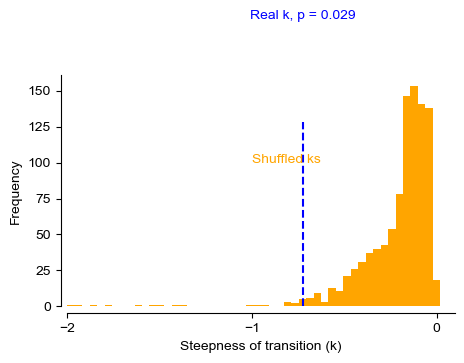

In [28]:
color_shuf = "orange"
color_real = "blue"

bins = np.linspace(-2, 2, 100)
f, ax = plt.subplots(figsize=(5, 3))

ax.hist(shuffled_k, bins=bins, color=color_shuf)
ax.axvline(real_k, ymax=0.8, linestyle="--", color=color_real)

sns.despine(ax=ax, offset=5)
ax.set_xlim(-2, 0.1)
ax.set_xticks([-2, -1, 0])
ax.text(real_k, 200,
        "Real k, p = {:2.3f}".format(1 - np.sum(shuffled_k > real_k) / num_repeats),
        ha="center",
        color=color_real)

ax.text(-1, 100, "Shuffled ks", color=color_shuf)

ax.set_ylabel("Frequency")
ax.set_xlabel("Steepness of transition (k)")

In [29]:
# to calculate difference before and after to see whether realigning worked

transition = 0
before = z.query("trial_aligned < @transition").auc_vel.mean()
after = z.query("trial_aligned >= @transition").auc_vel.mean()
print(f"Before transition: {before:.2f}, After transition: {after:.2f}, Difference: {after - before:.2f}")

Before transition: -1.86, After transition: 0.88, Difference: 2.74


In [30]:
for transition in np.arange(1, 48):
    before = z.query("trial < @transition").auc_vel.mean()
    after = z.query("trial >= @transition").auc_vel.mean()
    print(f"{transition}, Before transition: {before:.2f}, After transition: {after:.2f}, Difference: {after - before:.2f}")

1, Before transition: -1.56, After transition: -0.06, Difference: 1.50
2, Before transition: -1.69, After transition: -0.02, Difference: 1.67
3, Before transition: -1.96, After transition: 0.03, Difference: 1.99
4, Before transition: -2.04, After transition: 0.08, Difference: 2.12
5, Before transition: -2.29, After transition: 0.16, Difference: 2.44
6, Before transition: -2.36, After transition: 0.22, Difference: 2.59
7, Before transition: -2.39, After transition: 0.29, Difference: 2.68
8, Before transition: -2.42, After transition: 0.36, Difference: 2.78
9, Before transition: -2.33, After transition: 0.41, Difference: 2.74
10, Before transition: -2.21, After transition: 0.45, Difference: 2.66
11, Before transition: -2.25, After transition: 0.53, Difference: 2.79
12, Before transition: -2.34, After transition: 0.64, Difference: 2.98
13, Before transition: -2.29, After transition: 0.70, Difference: 2.99
14, Before transition: -2.24, After transition: 0.77, Difference: 3.00
15, Before tr

In [23]:
x_raw = z['trial'].to_numpy(dtype=float)
y_raw = z['auc_vel'].to_numpy(dtype=float)

m, b = np.polyfit(x_raw, y_raw, deg=1)
yhat = m * x_raw + b
r2_notaligned = 1 - np.sum((y_raw - yhat)**2) / np.sum((y_raw - y_raw.mean())**2)


x_raw = z['trial_aligned'].to_numpy(dtype=float)
y_raw = z['auc_vel'].to_numpy(dtype=float)

m, b = np.polyfit(x_raw, y_raw, deg=1)
yhat = m * x_raw + b
r2_aligned = 1 - np.sum((y_raw - yhat)**2) / np.sum((y_raw - y_raw.mean())**2)



r2_aligned

np.float64(0.17906297564862772)

In [ ]:
# function to calculate how many points above zero in different conditions
# could add to find ratio of before and after transition
# could also consider making the transition kick in later, i.e.
# after dopamine had gone below a certain point

def get_ratio_above_one(df, col, ntrials=10):

    df = df.query(f"{col} > -@ntrials and {col} < @ntrials")
    total_trials = len(df)

    return (df
            .assign(binary_auc=lambda df_: df_.auc_vel > 0)
            .query(f"{col} > 0")
            .binary_auc
            .sum()
            )

get_ratio_above_one(z, "trial_shifted")





# 169 vs 179
# 22 vs 16


np.int64(35)

In [53]:
col = "trials_shifted"

(z
.assign(binary_auc=lambda df_: df_.auc_vel > 0)
.query("@col < 0")
.binary_auc
.sum()
)

TypeError: '<' not supported between instances of 'str' and 'int'

{'n_samples': 392, 'slope': -0.026214737743582486, 'intercept': 0.8490223602076071, 'r2': 0.3419599255682594, 'adj_r2': 0.3402726433261267, 'slope_polyfit': -0.026214737743582503, 'intercept_polyfit': 0.8490223602076075}


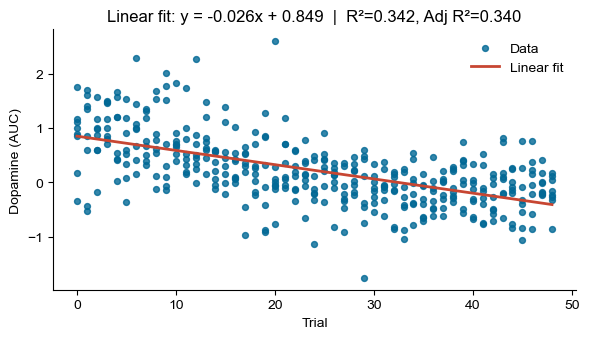

In [14]:
# Linear fit of auc_snips vs trial with R^2 and adjusted R^2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Extract x,y and drop NaNs
x_raw = z['trial'].to_numpy(dtype=float)
y_raw = z['auc_snips'].to_numpy(dtype=float)
mask = np.isfinite(x_raw) & np.isfinite(y_raw)
X = x_raw[mask].reshape(-1, 1)
y = y_raw[mask]

n = len(y)
p = 1  # number of predictors in linear model

if n < p + 2:
    print("Not enough points for a reliable linear fit.")
else:
    # Fit with scikit-learn
    lr = LinearRegression()
    lr.fit(X, y)
    y_pred = lr.predict(X)

    # Metrics
    r2 = r2_score(y, y_pred)
    adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1)) if (n - p - 1) > 0 else np.nan

    # Also compute via numpy.polyfit (sanity check)
    m_np, b_np = np.polyfit(X.ravel(), y, 1)

    print({
        'n_samples': int(n),
        'slope': float(lr.coef_[0]),
        'intercept': float(lr.intercept_),
        'r2': float(r2),
        'adj_r2': float(adj_r2),
        'slope_polyfit': float(m_np),
        'intercept_polyfit': float(b_np),
    })

    # Plot
    fig, ax = plt.subplots(figsize=(6, 3.5))
    ax.scatter(X.ravel(), y, s=18, color='#016895', alpha=0.8, label='Data')
    xs = np.linspace(X.min(), X.max(), 200)
    ax.plot(xs, lr.predict(xs.reshape(-1, 1)), color='#C74632', lw=2, label='Linear fit')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Dopamine (AUC)')
    ax.set_title(f"Linear fit: y = {lr.coef_[0]:.3f}x + {lr.intercept_:.3f}  |  R²={r2:.3f}, Adj R²={adj_r2:.3f}")
    try:
        import seaborn as sns
        sns.despine(ax=ax)
    except Exception:
        pass
    ax.legend(frameon=False)
    plt.tight_layout()
    plt.show()